This example allows you calculate the transmission through a device, once you have all the necessary modes to do so (i.e., their complex effective index). 

It loads the effective index, as a function of wavelength, of all relevant modes needed to calculate the transmission in the plasmonic mode and the dielectric mode of a two-waveguide two-mode system. It is based on the simplified coupled mode formalism shown in

## "Plasmonic sensors beyond the phase matching condition: a simplified  approach" 

By Alessandro Tuniz, Alex Y. Song, Giuseppe Della Valle, and C. Martijn de Sterke 

Submitted to MDPI Sensors (2022)

For research purposes only. Please cite the above paper if using any portion of this code for your research.

Creative Commons License (LICENSE-CC-BY-NC-SA).

Written by Alessandro Tuniz

As described in the paper, we need to load:

1) The *isolated* mode effective index as a function of wavelength for each case:

    i) lossless (neff_lossless_dielectric,neff_lossless_plasmonics)
    
    ii) lossy (neff_lossless_dielectric,neff_lossy_plasmonic)
    
    
2) The *coupled super-modes* effective index as a function of wavelength for each case: 
    
    i) lossless (neff_lossless_1, neff_lossless_2)
    
    ii) lossy (neff_lossy_1,neff_lossy_2)
    
We can then use this to get the resonant spectra of a plasmonic device of length *L* as a function of wavelength, 
for each analyte, using coupled mode theory (CMT), which *only* uses mode calculations, but still accounts for mode interactions in the device. This code assumes that all the power at the beginning of the device to be in the dielectric waveguide, and looks at the power in the dielectric mode at the end of the device, after coupling to the plasmonic mode has occurred.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
import scipy as sp
from scipy.optimize import fsolve
from mpmath import mp
from IPython.display import clear_output
import os
import sys
import time
from IPython.display import display, clear_output
import matplotlib as mpl
import importlib as importlib
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.io import savemat
from scipy.io import loadmat

# some global variables

global e0 
global c0

e0 = 8.85418787162e-12 # permittivity of free space
c0 = 299792458 # speed of light


In [2]:
sys.path.insert(1, 'functions/')
sys.path.insert(1, 'data/')

import sensors as sensors # all the important functions are in here



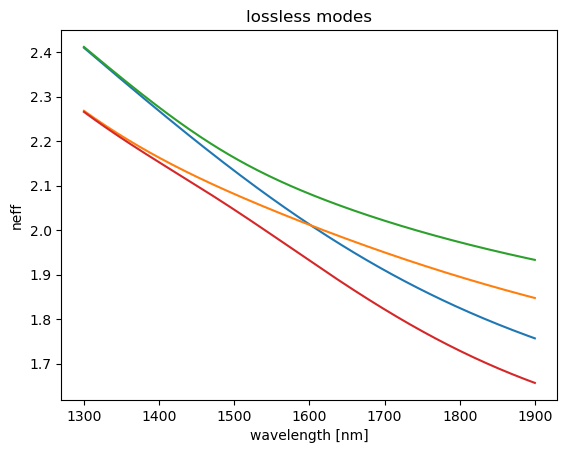

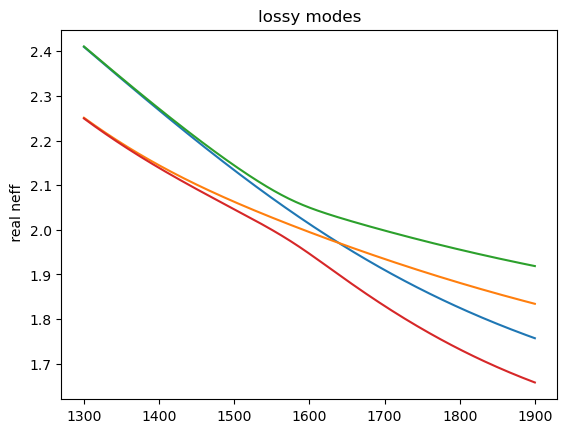

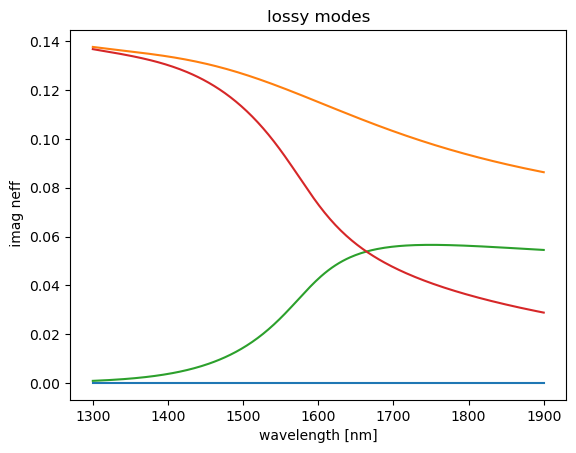

In [3]:
wavelength_range = np.real(np.loadtxt('data/na_1.42_neff_dielectric_isolated_lossless.txt',dtype=complex,skiprows=1))[:,0]
analyte_index = np.real(np.loadtxt('data/na_1.42_neff_dielectric_isolated_lossless.txt',dtype=complex,skiprows=1))[:,1]

# 1(i) lossless isolated modes
neff_lossless_dielectric = (np.loadtxt('data/na_1.42_neff_dielectric_isolated_lossless.txt',dtype=complex,skiprows=1))[:,2]
neff_lossless_plasmonic = (np.loadtxt('data/na_1.42_neff_plasmonic_isolated_lossless.txt',dtype=complex,skiprows=1))[:,2]

# 1(ii) lossless super modes
neff_lossless_1 = (np.loadtxt('data/na_1.42_neff_supermode1_lossless.txt',dtype=complex,skiprows=1))[:,2]
neff_lossless_2 = (np.loadtxt('data/na_1.42_neff_supermode2_lossless.txt',dtype=complex,skiprows=1))[:,2]

# 2(i) lossy isolated modes (note: dielectric is always lossless...)
neff_lossless_dielectric = (np.loadtxt('data/na_1.42_neff_dielectric_isolated_lossless.txt',dtype=complex,skiprows=1))[:,2]
neff_lossy_plasmonic = (np.loadtxt('data/na_1.42_neff_plasmonic_isolated_lossy.txt',dtype=complex,skiprows=1))[:,2]

# 2(ii) lossy supermodes
neff_lossy_1 = (np.loadtxt('data/na_1.42_neff_supermode1_lossy.txt',dtype=complex,skiprows=1))[:,2]
neff_lossy_2 = (np.loadtxt('data/na_1.42_neff_supermode2_lossy.txt',dtype=complex,skiprows=1))[:,2]

plt.figure()
plt.plot(wavelength_range,np.real(neff_lossless_dielectric))
plt.plot(wavelength_range,np.real(neff_lossless_plasmonic))
plt.plot(wavelength_range,np.real(neff_lossless_1))
plt.plot(wavelength_range,np.real(neff_lossless_2))
plt.xlabel('wavelength [nm]')
plt.ylabel('neff')
plt.title('lossless modes')
plt.show()

plt.figure(1)
plt.plot(wavelength_range,np.real(neff_lossless_dielectric))
plt.plot(wavelength_range,np.real(neff_lossy_plasmonic))
plt.plot(wavelength_range,np.real(neff_lossy_1))
plt.plot(wavelength_range,np.real(neff_lossy_2))
plt.title('lossy modes')
plt.ylabel(' real neff')
plt.show()

plt.figure(2)
plt.plot(wavelength_range,np.imag(neff_lossless_dielectric))
plt.plot(wavelength_range,np.imag(neff_lossy_plasmonic))
plt.plot(wavelength_range,np.imag(neff_lossy_1))
plt.plot(wavelength_range,np.imag(neff_lossy_2))
plt.xlabel('wavelength [nm]')
plt.ylabel(' imag neff')
plt.title('lossy modes')
plt.show()





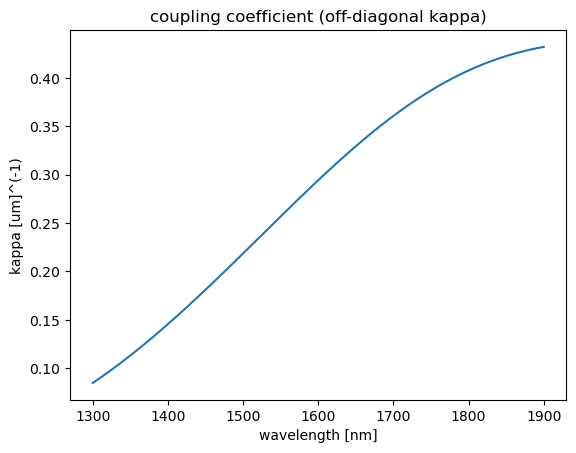

In [8]:
# write the lossy modes as propagation constants for CMT 
wavelength_range_in_m = wavelength_range*1e-9 # wavelength  in meters
k0 = (2*np.pi/wavelength_range_in_m) # free space wavenumber

beta1 = k0*neff_lossless_dielectric # isolated dielectric mode goes in CMT
beta2 = k0*neff_lossy_plasmonic # isolated plasmonic lossy mode goes in CMT

# get kappa from the above lossless modes
DELTA = k0*(neff_lossless_1-neff_lossless_2)/2     # \tilde{\Delta} in Eq. (8) of the paper
delta = k0*(neff_lossless_dielectric-neff_lossless_plasmonic)/2     # \Delta in Eq. (8)  of the paper (lossless modes)
kappa_CMT = np.sqrt(DELTA**2-delta**2)  # \kappa in Eq. (8) from lossless case goes in CMT

plt.figure()
plt.plot(wavelength_range,np.real(kappa_CMT)*1e-6)
plt.title('coupling coefficient (off-diagonal kappa)')
plt.ylabel('kappa [um]^(-1)')
plt.xlabel('wavelength [nm]')
plt.show()


In [9]:
# pick a length over which to propagate
L_device = 10e-6

# create the propagation array in z, here called ZZ, with array length NN=10 for speed
NN = 10
ZZ = np.linspace(0,L_device,NN)+0*1j

##  calculate the transmission with a simple function
## CMT calculates the field at every point in propagation Z
## therefore, we calculate Transmission_total(z) and then the transmission at the end of the device is the last element..
Transmission = np.zeros(len(wavelength_range))
for kn in range(0,len(wavelength_range)):
    clear_output(wait=True)
    print("patience.. CMT approach running.. " + str(float(kn+1)/float(wavelength_range.size)*100)+" % wavelengths complete")
    Transmission_total = sensors.coupled_mode_theory(ZZ,beta1[kn],beta2[kn],kappa_CMT[kn])
    Transmission[kn] = Transmission_total[-1]
    

patience.. CMT approach running.. 100.0 % wavelengths complete


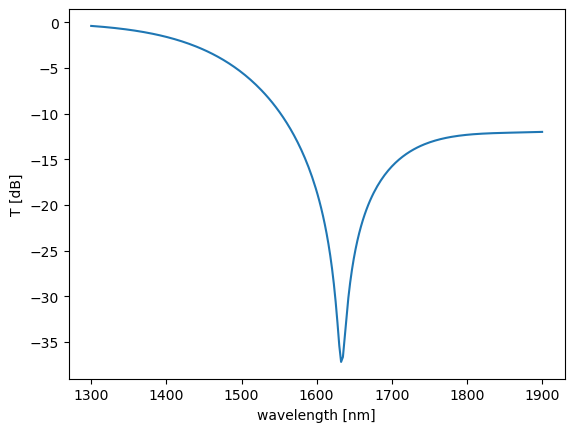

In [10]:
plt.figure()
plt.plot(wavelength_range,10*np.log10(Transmission))
plt.ylabel('T [dB]')
plt.xlabel('wavelength [nm]')
plt.show()